## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


`1.` What is the distribution of how many articles a user interacts with in the dataset?

In [3]:
n_artical = df.groupby('email')['article_id'].count()
n_artical.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

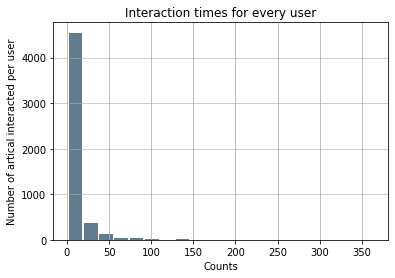

In [4]:
n_artical.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Interaction times for every user')
plt.xlabel('Counts')
plt.ylabel('Number of artical interacted per user')
plt.grid(axis='y', alpha=0.75)

In [5]:
median_val = n_artical.median()# 50% of individuals interact with __3__ number of articles or fewer.
max_views_by_user = n_artical.max()# The maximum number of user-article interactions by any 1 user is ___364___.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
df_content = df_content.drop_duplicates(subset =['article_id'], keep='first')

`3.` 

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
unique_articles = len(df['article_id'].unique()) # The number of unique articles that have at least one interaction
total_articles = len(df_content['article_id'].unique())# The number of unique articles on the IBM platform
unique_users = len(df['email'].unique()) - 1# The number of unique users
user_article_interactions = len(df)# The number of user-article interactions

`4.` Find the most viewed **article_id**, as well as how often it was viewed. 

In [9]:
n_view = df.groupby('article_id')['email'].count()

In [10]:
most_viewed_article_id = str(n_view[n_view == n_view.max()].index[0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = n_view.max()# The most viewed article in the dataset was viewed how many times?

In [11]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In [12]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    n_interaction = df.groupby('title')['user_id'].count()
    top_articles = list(n_interaction.nlargest(n).index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    n_interaction = df.groupby('article_id')['user_id'].count()
    top_articles = list(n_interaction.nlargest(n).index)
 
    return top_articles # Return the top article ids

In [13]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

In [14]:
# reformat the df dataframe to be shaped with users as the rows and articles as the columns

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix 

    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(["user_id", "article_id"])["title"].count().unstack()

    user_item = user_item.fillna(value=0)

    user_item[user_item > 0] = 1

    return user_item



In [15]:
user_item = create_user_item_matrix(df)

In [16]:
# provide an ordered list of the most similar users to that user (from most similar to least similar)
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered

    '''
    # compute similarity of each user to the provided user
    similar_mat = user_item.dot(user_item[user_item.index == user_id].T)
    # sort by similarity
    most_similar_users = similar_mat.sort_values(user_id, ascending=False).index.values[1:]

    return list(most_similar_users)

In [17]:
# the articles recommended to each user.
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(df.loc[df['article_id'].isin(article_ids)]['title'].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item = user_item, df_content = df_content):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
                    （there are not enough data in df_content so I use df instead)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    ids = list(user_item.columns[user_item.loc[user_id]==1])
    article_ids = list(map(lambda x:str(x), ids))
    article_names = get_article_names(ids, df=df)
    
    
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # seen by user 
    seen = get_user_articles(user_id)[0]
    closest_users = find_similar_users(user_id)

    recs = list()

    for user in closest_users:
        users_likes = get_user_articles(user)[0]

        new_recs = list(set(users_likes)-set(seen))
        recs.extend(new_recs)
        seen.extend(new_recs)
        
        if len(recs) >m-1:
            break
    recs = recs[:m]
    

    return recs # return your recommendations for this user_id 

In [18]:
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['use sql with data in hadoop python',
 'analyzing data by using the sparkling.data library features',
 'experience iot with coursera',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'variational auto-encoder for "frey faces" using keras',
 'machine learning and the science of choosing',
 'higher-order logistic regression for large datasets',
 'this week in data science (may 2, 2017)',
 'deep learning achievements over the past year ',
 'analyze facebook data using ibm watson and watson studio']

In [19]:
# improve the consistency of the **user_user_recs** function from above.  
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    interactions = df.groupby('user_id')['article_id'].count()
    neighbors_df = pd.DataFrame(columns = ['neighbor_id','similarity','num_interactions'])
    for ui in list(user_item.index):
        neighbors_df.loc[ui,'neighbor_id']=ui
        neighbors_df.loc[ui,'similarity'] = (user_item.loc[ui]*user_item.loc[user_id]).sum()
        neighbors_df.loc[ui,'num_interactions'] = interactions[ui]
    
    neighbors_df = neighbors_df.sort_values(by = ['similarity','num_interactions'],ascending=False)\
                .drop(index = user_id).reset_index().drop(columns=['index'])
    
    
    return neighbors_df # Return the dataframe specified in the doc_string


In [20]:
artical_int_rank = df.groupby('article_id')['user_id'].count().rank(ascending=False).sort_values()
for id in df['article_id']:
    df.loc[df[df['article_id'] == id].index, 'artical_int_rank'] = artical_int_rank[id]

In [21]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    if user_id in list(df['user_id']):
        seen = get_user_articles(user_id)[0]
        closest_users = get_top_sorted_users(user_id)['neighbor_id']
        recs = list()

        for user in closest_users:
            users_likes = list(df[df['user_id']==user].sort_values(by = ['artical_int_rank'])['article_id'])

            new_recs = list(set(users_likes)-set(seen))
            recs.extend(new_recs)
            seen.extend(new_recs)

            if len(recs) == m:
                break
                
    else:
        recs = list(df.sort_values(by = ['artical_int_rank'])['article_id'].unique())
        
    recs = recs[0:m]
    rec_names = get_article_names(recs)
    rec_ids = list(map(lambda x:str(x), recs))
    return rec_ids, rec_names

In [22]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '12.0', '1296.0', '1304.0', '793.0', '555.0', '1324.0', '302.0', '1329.0', '1330.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'ibm watson facebook posts for 2015', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'accelerate your workflow with dsx', 'fortune 100 companies', '10 powerful features on watson data platform, no coding necessary', 'using deep learning to reconstruct high-resolution audio', 'ingest data from message hub in a streams flow', 'build a naive-bayes model with wml & dsx']


In [25]:
new_user_recs = user_user_recs_part2(0)
print("The top 10 recommendations for user 0 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 0 are the following article names:")
print(rec_names)

The top 10 recommendations for user 0 are the following article ids:
['1024.0', '12.0', '1296.0', '1304.0', '793.0', '555.0', '1324.0', '302.0', '1329.0', '1330.0']

The top 10 recommendations for user 0 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'ibm watson facebook posts for 2015', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'accelerate your workflow with dsx', 'fortune 100 companies', '10 powerful features on watson data platform, no coding necessary', 'using deep learning to reconstruct high-resolution audio', 'ingest data from message hub in a streams flow', 'build a naive-bayes model with wml & dsx']


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In [38]:
# Perform SVD on the User-Item Matrix
user_item_matrix = create_user_item_matrix(df)
u, s, vt = np.linalg.svd(user_item_matrix)
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

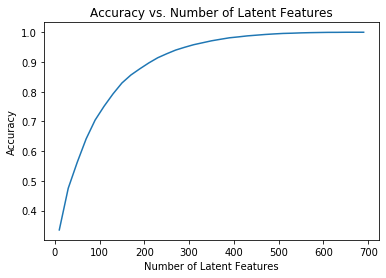

In [39]:
# as the number of latent features increases, 
# we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

What's more, I want to address the following questions: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [40]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = df_test['user_id'].unique()
    
    test_arts = df_test['article_id'].unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [41]:
i = 0
for user in test_idx:
    if user in list(df_train['user_id'].unique()):
        i+=1
i

20

We can see that there are only 20 users can be predicted.\
Then I want to explore how well SVD works towards making predictions for recommendations on the test data. 

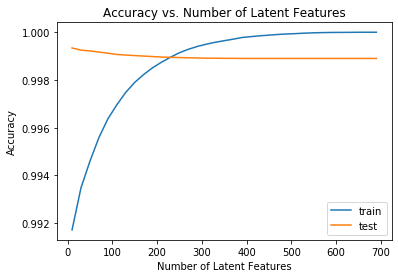

In [45]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

row_idx = user_item_train.index.isin(test_idx)
col_idx = user_item_train.columns.isin(test_arts)

u_test = u_train[row_idx, :]
vt_test = vt_train[:, col_idx]

user_item_test_pred = user_item_test.loc[same_user]

num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_new_test, u_new_test, vt_new_test = np.diag(s_train[:k]), u_test[:, :k], vt_test[:k, :]

    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    user_item_test_est = np.around(np.dot(np.dot(u_new_test, s_new_test), vt_new_test))

    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_pred, user_item_test_est)

    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)


plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]), label="train")
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label="test")
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

We can see that for the test matrix, the accuracy declines as the number of features increases. The best number of Latent Features is the x of intersecting point, which is around 230.

In [58]:
df_accuracy = pd.DataFrame(
    {'k' : num_latent_feats, 
     'accuracy_train' : np.around(1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]),5),
     'accuracy_test' : np.around(1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]),5)})

In [60]:
df_accuracy[df_accuracy['accuracy_train']==df_accuracy['accuracy_test']]['k']

11    230
Name: k, dtype: int64